In [2]:
"""Useful modules"""
import numpy as np
import matplotlib.pyplot as plt

"""Setting the random seed"""
np.random.seed(0)

# Q1

In [3]:
class myStochasticDescender():
        
        def __init__(self,nneurons):
            """Initial variables and weights and biases, along with a status for reporting."""
            self.l = len(nneurons)
            self.W = [np.random.randn(nneurons[i+1],nneurons[i]) for i in range(self.l-1)]
            self.b = [np.random.randn(nneurons[i+1],1) for i in range(self.l-1)]
            self.fitted=False
            
            
        def logsig(self,x):
            """This is the logistic sigmoid used in the loss function calculagtion. 
            We could sub this for alternatives, like tanh."""
            return np.divide(1,1+np.exp(-x))
        
        def predict(self,X):
            """This method runs the inputted data set through the currently configured activation functions
            and returns the probability of a data set's label being 1."""
            n = X.shape[1]
            A=[[] for i in range(self.l)]
            A[0]=X
            for i in range(1,self.l):
                A[i]=self.logsig(np.matmul(self.W[i-1],A[i-1])+np.repeat(self.b[i-1],n,1))
            a=A[self.l-1].reshape(-1)
            return a
        
        def predict_binary(self,X):
            """This method converts the probabiities in the predict method to binary labels."""
            binary = self.predict(X)
            binary[np.where(binary>0.5)] = 1
            binary[np.where(binary<=0.5)] = 0
            return binary
        
        def plot_predict(self,X):
            """This method plots the results of the predict method above."""
            plt.scatter(X[0,:],X[1,:],10,self.predict(X))
            plt.show()
            
        def plot_binary(self,X):
            """This method plots the results of the binary prediction method above."""
            labels = self.predict_binary(X)
            plt.plot(X[0,labels==0],X[1,labels==0],'x',color='red',label='class 0')
            plt.plot(X[0,labels==1],X[1,labels==1],'d',color='blue',label='class 1')
            plt.xlabel('$x_1$')
            plt.ylabel('$x_2$')
            plt.legend()
            plt.show()
            
        def loss(self,X,y):
            """This is the loss function we want to minimise."""
            a=self.predict(X)
            return np.mean(-y*np.log(a)-(1-y)*np.log(1-a))

        def accuracy(self,X,y):
            """This method calculates the accuracy ((TP+TN)/(TP+TN+FP+FN)) of the data given a set of labels."""
            results = self.predict_binary(X)
            accuracy = np.sum(results==y)/y.shape[0]
            return accuracy
        
        def train(self,X,y,learning_rate):
            """This is one iteration of gradient descent.
            It is meant to be ran repeatedly with an appropriate minimising function."""
            # forwards pass
            n = X.shape[1]
            A=[[] for i in range(self.l)]
            A[0]=X
            for i in range(1,self.l):
                A[i]=self.logsig(np.matmul(self.W[i-1],A[i-1])+np.repeat(self.b[i-1],n,1))
            
            # backwards pass
            D=[[] for i in range(self.l)]
            D[self.l-1]=-y*(1-A[self.l-1])+(1-y)*A[self.l-1]
            for i in range(2,self.l):
                D[self.l-i]=np.matmul(self.W[self.l-i].T,D[self.l-i+1])*A[self.l-i]*(1-A[self.l-i])
            
            # update weights and biases
            for i in range(self.l-1):
                self.W[i]=self.W[i]-learning_rate*np.matmul(D[i+1],A[i].T)
                self.b[i]=self.b[i]-learning_rate*np.sum(D[i+1],1).reshape(-1,1)
                
        def fit(self,X,y,early_stopping=True,max_its=0,min_its=100,
                train_test_ratio=0.8,traintrain_val_ratio=0.7,
                batch_size=0,learning_rate=1e-4,its_per_check=10,stop_tol=1e-4,
                plot_descent=False,report_accuracy=True,plot_test=True):
            """This method fits weights and biases to the model's given neural network using stochastic descent.
            If defaults to using a batch size of 10% (rounded up) of the total given data if 
            no preference is set. You can also switch it to ignore early stopping, in which case it will just
            use the training error combined with the stopping tolerance.
            Note that setting the batch size equal to the size of the data points turns this into a gradient
            descent."""
            X_train = X[:,:int(np.floor(X.shape[1]*train_test_ratio))]
            y_train = y[:int(np.floor(y.shape[0]*train_test_ratio))]
            X_test = X[:,int(np.floor(X.shape[1]*train_test_ratio)):]
            y_test = y[int(np.floor(y.shape[0]*train_test_ratio)):]
            if early_stopping==True:
                X_traintrain = X_train[:,:int(np.floor(X.shape[1]*traintrain_val_ratio))]
                y_traintrain = y_train[:int(np.floor(y.shape[0]*traintrain_val_ratio))]
                X_val = X_train[:,int(np.floor(X.shape[1]*traintrain_val_ratio)):]
                y_val = y_train[int(np.floor(y.shape[0]*traintrain_val_ratio)):]
                if batch_size == 0:
                    self.batch_size = int(np.ceil(X_traintrain.shape[1]*0.1))
                else:
                    self.batch_size = batch_size
                training_error=[self.loss(X_traintrain,y_traintrain)]
                validation_error=[self.loss(X_val,y_val)]
                done=False
                its=0
                while done==False:
                    for updates in range(its_per_check):
                        its=its+1
                        if max_its != 0:
                            if its >= max_its:
                                done = True
                        else:
                            p=np.random.permutation(int(np.floor(X.shape[1]*traintrain_val_ratio)))
                            subset=p[:self.batch_size]
                            self.train(X_traintrain[:,subset],y_traintrain[subset],learning_rate)
                    training_error.append(self.loss(X_traintrain,y_traintrain))
                    validation_error.append(self.loss(X_val,y_val))
                    if its>min_its and validation_error[-1]>validation_error[-2]-stop_tol:
                        done=True
                self.train(X_train,y_train,learning_rate)
                if plot_descent == True:        
                    plt.semilogy(np.linspace(0,its,len(training_error)),training_error)
                    plt.semilogy(np.linspace(0,its,len(validation_error)),validation_error)
                    plt.xlabel('iterations')
                    plt.ylabel('loss')
                    plt.legend(('Training error','Testing error'))
                    plt.show()
            
            else:
                n = X_train.shape[1]
                if batch_size == 0:
                    self.batch_size = int(np.ceil(X_train.shape[1]*0.1))
                else:
                    self.batch_size = batch_size
                training_error=[self.loss(X,y)]
                done=False
                its=0
                while done==False:
                    for updates in range(its_per_check):
                        its=its+1
                        if max_its != 0:
                            if its >= max_its:
                                done = True
                        else:
                            p=np.random.permutation(n)
                            subset=p[:self.batch_size]
                            self.train(X_train[:,subset],y_train[subset],learning_rate)
                    training_error.append(self.loss(X,y))                
                    if its>min_its and training_error[-1]<training_error[-2]-stop_tol:
                        done=True
                if plot_descent == True:        
                    plt.semilogy(np.linspace(0,its,len(training_error)),training_error)
                    plt.xlabel('iterations')
                    plt.ylabel('loss')
                    plt.legend('Training error')
                    plt.show()
            
            if report_accuracy == True:
                print('Model accuracy on test data = '+str(self.accuracy(X_test,y_test)))
            if plot_test == True:
                self.plot_binary(X_test)
            self.fitted=True
            self.X = X
            self.y = y

In [4]:
def plot_data(X,y):
    plt.plot(X[0,y==0],X[1,y==0],'x',color='red',label='class 0')
    plt.plot(X[0,y==1],X[1,y==1],'d',color='blue',label='class 1')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.show()

# Q2

# Example 1

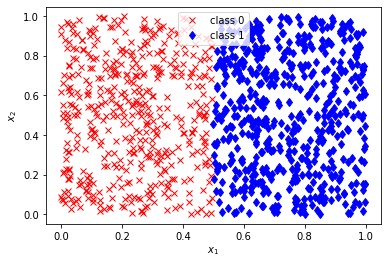

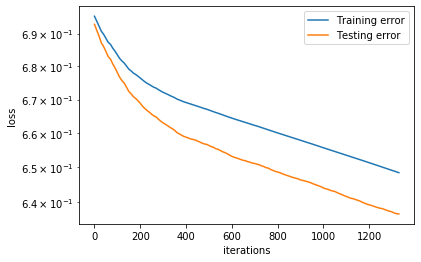

Model accuracy on test data = 0.755


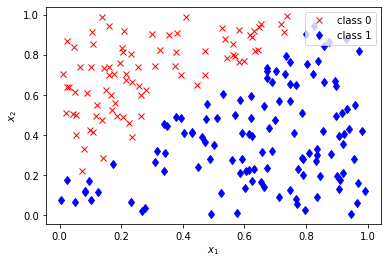

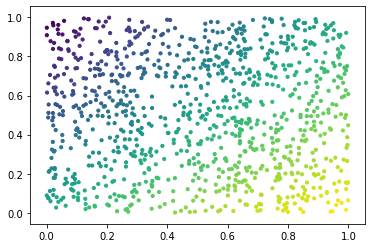

In [9]:
def data1(n):
    X=np.random.uniform(0,1,(2,n))
    y=(X[0,:]>0.5)*1
    return X,y

X1,y1=data1(1000)
plot_data(X1,y1)

ex1 = myStochasticDescender([2,5,1])
ex1.fit(X1,y1,max_its=0,plot_descent=True)
ex1.plot_predict(X1)

This example of linearly separable data tends to have very mixed results with a very simple (2,5,1) network, but can still achieve a high accuracy score even under these conditions. 

# Example 2

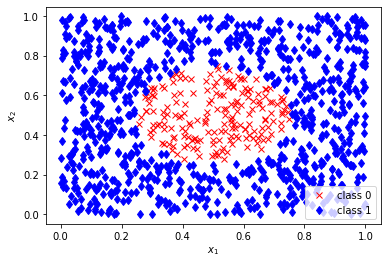

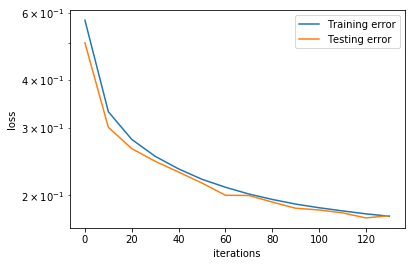

Model accuracy on test data = 0.95


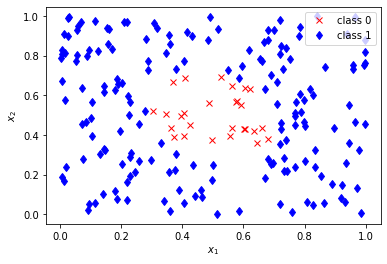

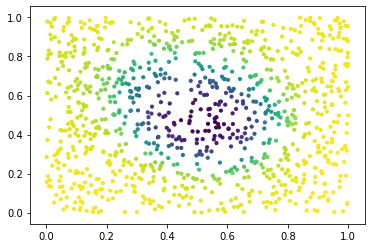

In [5]:
def data2(n):
    X=np.random.uniform(0,1,(2,n))
    y=((X[0,:]-0.5)**2+(X[1,:]-0.5)**2>0.25**2)*1
    return X,y

X2,y2=data2(1000)
plot_data(X2,y2)

ex2 = myStochasticDescender([2,1000,100,100,1])
ex2.fit(X2,y2,batch_size=250,plot_descent=True)
ex2.plot_predict(X2)

This example of separable (but not linearly separable data) requires a more complicated model to achieve good accuracy, and generally needs a larger batch size as well. Otherwise, the class 0 data tends to dominate and the class 1 results are minimal if not ignored outright.

# Example 3

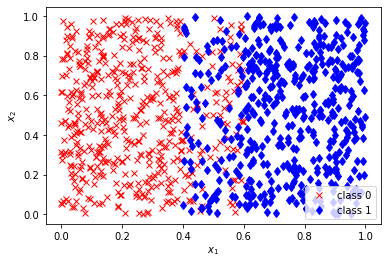

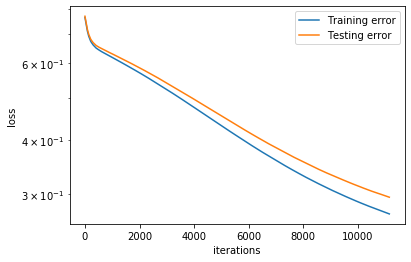

Model accuracy on test data = 0.895


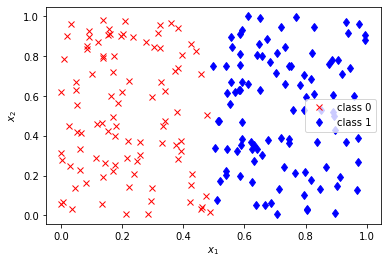

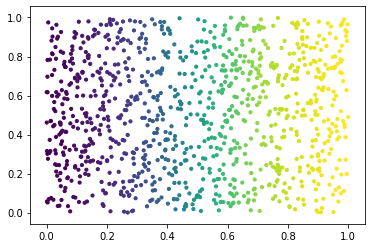

In [20]:
def data3(n):
    X=np.random.uniform(0,1,(2,n))
    y=np.zeros(n)
    for i in range(n):
        if X[0,i]<0.4:
            y[i]=0
        else:
            if X[0,i]<0.6:
                y[i]=np.random.randint(2)
            else:
                y[i]=1
    return X,y

X3,y3=data3(1000)
plot_data(X3,y3)

ex3 = myStochasticDescender([2,5,1])
ex3.fit(X3,y3,plot_descent=True,min_its=10000)
ex3.plot_predict(X3)

This example of nearly linearly separable data can also achieve relatively high accuracy with even a simple method, but again the results can vary quite a bit. As expected, it tends to be more accurate at the edges where there is no mixing, and at times compensates for the mixed nature by dividing the middle at unexpected angles.

# Example 4

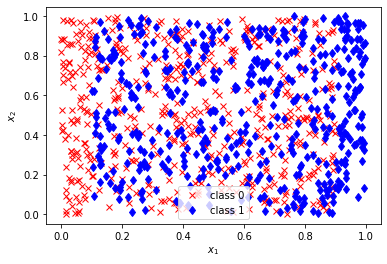

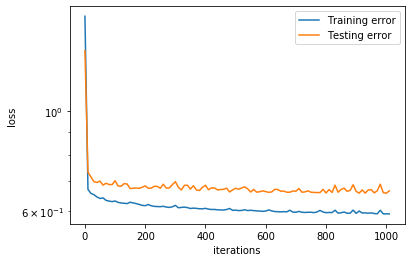

Model accuracy on test data = 0.515


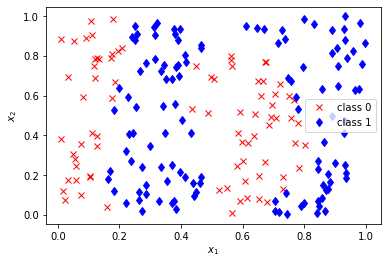

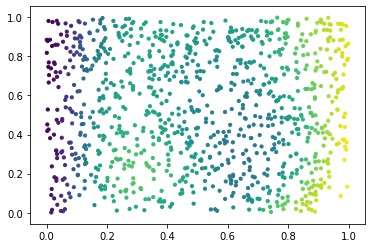

In [21]:
def data4(n):
    X=np.random.uniform(0,1,(2,n))
    y=np.zeros(n)
    for i in range(n):
        if X[0,i]<0.1:
            y[i]=0
        elif X[0,i]<0.9:
            y[i]=np.random.randint(2)
        else:
            y[i]=1
    return X,y

X4,y4=data4(1000)
plot_data(X4,y4)

ex4 = myStochasticDescender([2,1000,100,100,1])
ex4.fit(X4,y4,batch_size=500,plot_descent=True,min_its=1000)
ex4.plot_predict(X4)

This example of highly mixed data tends to perform poorly even with very big networks. It will usually either generalise one class across all results, or have one dominate the other. More complicated networks do tend to capture the unmixed edges though.

# Example 5

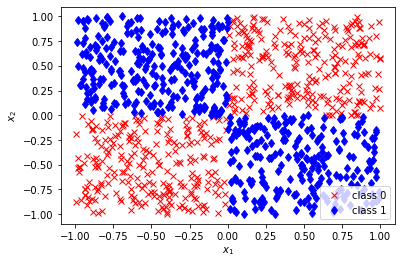

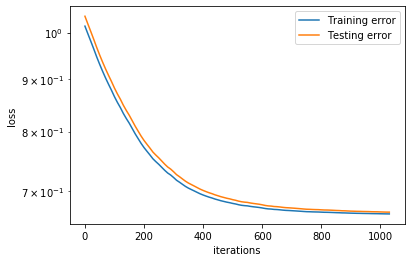

Model accuracy on test data = 0.54


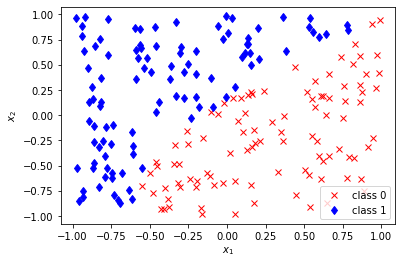

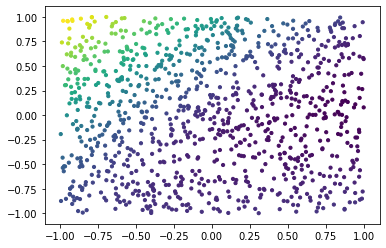

In [22]:
n=1000
X5=np.random.uniform(-1,1,(2,n))
u=1
y5=(np.sin(u*np.pi*X5[0,:])*(np.sin(u*np.pi*X5[1,:]))<0)*1

plot_data(X5,y5)

ex5 = myStochasticDescender([2,5,1])
ex5.fit(X5,y5,plot_descent=True,min_its=1000)
ex5.plot_predict(X5)

This example of squared data can achieve high accuracy scores, but this also requires a complex network to achieve. Scores as high as 99% are possible though, due to the distinctive borders of the data.

# Q3

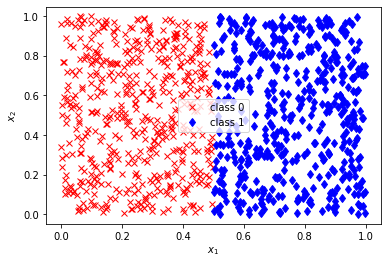

Model accuracy on test data = 0.99


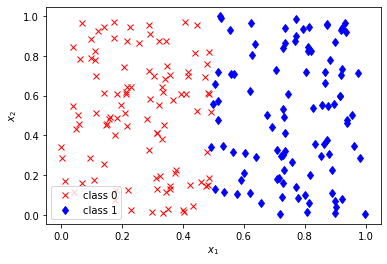

Model accuracy on test data = 0.995


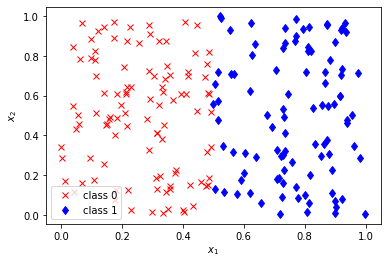

Loss for first low point
0.05715584445232282

Weights for first low point
[array([[ 5.28325299,  0.46039873],
       [-5.24414753,  0.71862931]]), array([[-4.36025978,  2.99455085],
       [-4.83227089,  5.16255009]]), array([[-4.35209281, -7.02099415]])]

Loss for second low point
0.05677940638011827

Weights for second low point
[array([[ 1.94572692, -0.45314492],
       [-7.23331029,  0.03450838]]), array([[-1.44017311,  6.23388332],
       [-1.6435201 ,  5.55266556]]), array([[-6.39064216, -5.34784403]])]

Average loss of two low points
0.056967625416220545

Loss on midpoint
0.06366328877850295


In [9]:
np.random.seed(0)

X6,y6=data1(1000)
plot_data(X6,y6)

notConvex1 = myStochasticDescender([2,2,2,1])
notConvex1.fit(X6,y6,batch_size=1000)

notConvex2 = myStochasticDescender([2,2,2,1])
notConvex2.fit(X6,y6,batch_size=1000)

print('Loss for first low point')
print(notConvex1.loss(X6,y6))
print('\nWeights for first low point')
print(notConvex1.W)
print('\nLoss for second low point')
print(notConvex2.loss(X6,y6))
print('\nWeights for second low point')
print(notConvex2.W)

notConvex3 = myStochasticDescender([2,2,2,1])

notConvex3.W[0] = (notConvex1.W[0] + notConvex2.W[0])/2
notConvex3.W[1] = (notConvex1.W[1] + notConvex2.W[1])/2
notConvex3.W[2] = (notConvex1.W[2] + notConvex2.W[2])/2

notConvex3.b[0] = (notConvex1.b[0] + notConvex2.b[0])/2
notConvex3.b[1] = (notConvex1.b[1] + notConvex2.b[1])/2
notConvex3.b[2] = (notConvex1.b[2] + notConvex2.b[2])/2

print('\nAverage loss of two low points')
print((notConvex1.loss(X6,y6)+notConvex2.loss(X6,y6))/2)
print('\nLoss on midpoint')
print(notConvex3.loss(X6,y6))

In general, NLL(W,b) for neural networks is not a convex function. They can have many local minima of varying quality.

To demonstrate this, I have fitted the same data with the same network twice, using gradient descent to avoid the issue of randomness. This gives us two points with low values (though we won't prove they're minima, as it's possible and indeed likely they're not quite there perfectly). I've then averaged the weights and biases of the two to obtain the midpoint on the function, which returns a lower loss function value. 

Hence, the function is not convex as we've got a midpoint between two values with a higher loss than the average of the two original values.